<a href="https://colab.research.google.com/github/waratip/TestData/blob/main/Face_%2B_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -U retinaface_pytorch > /dev/null
!pip install facemask_detection  > /dev/null

In [37]:
!wget -O crowd.jpg https://habrastorage.org/webt/9e/pt/rs/9eptrsrhqoxcj1zbxzpadvn9gtu.jpeg > /dev/null

--2021-06-01 08:42:19--  https://habrastorage.org/webt/9e/pt/rs/9eptrsrhqoxcj1zbxzpadvn9gtu.jpeg
Resolving habrastorage.org (habrastorage.org)... 82.192.95.170
Connecting to habrastorage.org (habrastorage.org)|82.192.95.170|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/9e/pt/rs/9eptrsrhqoxcj1zbxzpadvn9gtu.jpeg [following]
--2021-06-01 08:42:21--  https://hsto.org/webt/9e/pt/rs/9eptrsrhqoxcj1zbxzpadvn9gtu.jpeg
Resolving hsto.org (hsto.org)... 172.67.71.175, 104.26.13.161, 104.26.12.161, ...
Connecting to hsto.org (hsto.org)|172.67.71.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221539 (216K) [image/jpeg]
Saving to: ‘crowd.jpg’

crowd.jpg           100%[===================>] 216.35K  --.-KB/s    in 0.009s  

2021-06-01 08:42:21 (24.1 MB/s) - ‘crowd.jpg’ saved [221539/221539]



In [38]:
import cv2
import albumentations as A
import torch
import numpy as np

In [39]:
from tqdm import tqdm

In [40]:
from matplotlib import pyplot as plt
from retinaface.pre_trained_models import get_model as get_detector
from facemask_detection.pre_trained_models import get_model as get_classifier

In [41]:
plt.rcParams["figure.figsize"] = (15, 15)

In [42]:
image = cv2.imread("test-1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

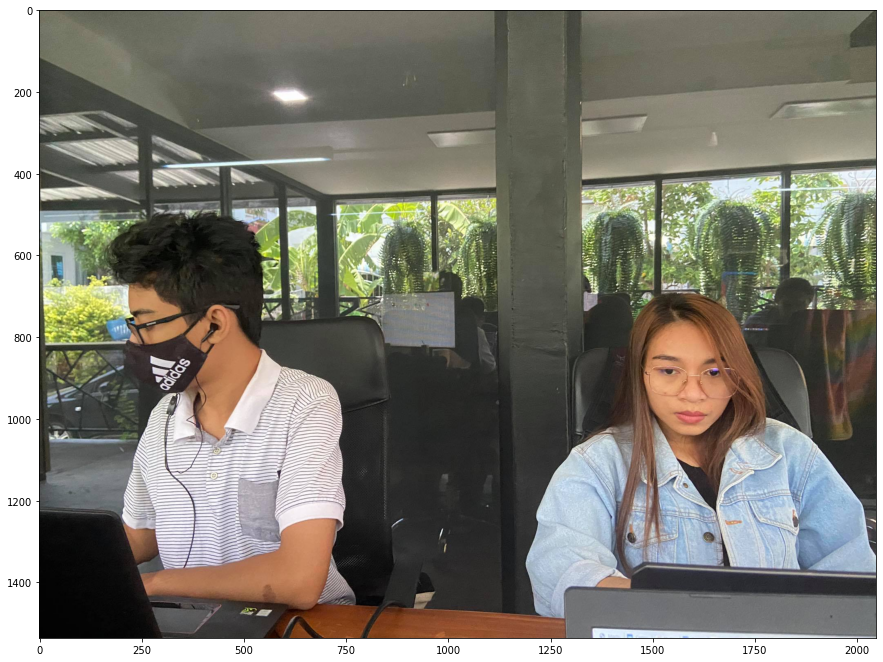

In [43]:
plt.imshow(image)

In [44]:
face_detector = get_detector("resnet50_2020-07-20", max_size=800)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [45]:
face_detector.eval()

In [46]:
with torch.no_grad():
  annotations = face_detector.predict_jsons(image)

In [47]:
len(annotations)

2

In [48]:

print(annotations)

[{'bbox': [1477, 757, 1694, 1039], 'score': 0.9968327879905701, 'landmarks': [[1542, 886], [1649, 887], [1602, 944], [1557, 983], [1632, 985]]}, {'bbox': [194, 634, 399, 936], 'score': 0.9815419316291809, 'landmarks': [[238, 760], [256, 766], [215, 819], [254, 866], [268, 870]]}]


In [49]:
mask_classifier = get_classifier("tf_efficientnet_b0_ns_2020-07-29")
mask_classifier.eval();

/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [50]:
transform = A.Compose([A.SmallestMaxSize(max_size=256, p=1), 
                       A.CenterCrop(height=224, width=224, p=1),
                       A.Normalize(p=1)])

In [51]:
predictions = []

with torch.no_grad():
  for annotation in tqdm(annotations):
    x_min, y_min, x_max, y_max = annotation['bbox']

    x_min = np.clip(x_min, 0, x_max)
    y_min = np.clip(y_min, 0, y_max)
    
    crop = image[y_min:y_max, x_min:x_max]
    
    crop_transformed = transform(image=crop)['image']
    model_input = torch.from_numpy(np.transpose(crop_transformed, (2, 0, 1)))  

    predictions += [mask_classifier(model_input.unsqueeze(0))[0].item()]  
  

100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


In [52]:
vis_image = image.copy()

for prediction_id, annotation in enumerate(annotations):
    is_mask = predictions[prediction_id] > 0.5
    if is_mask:
      color =(0, 255, 0)
      text = "mask"
    else:
      color =(255, 0, 0)   
      text = "no mask"

    x_min, y_min, x_max, y_max = annotation["bbox"]

    x_min = np.clip(x_min, 0, x_max - 1)
    y_min = np.clip(y_min, 0, y_max - 1)

    vis_image = cv2.rectangle(vis_image, (x_min, y_min), (x_max, y_max), color=color, thickness=2)

    
    vis_image = cv2.putText(vis_image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,  1, color, 2, cv2.LINE_AA) 



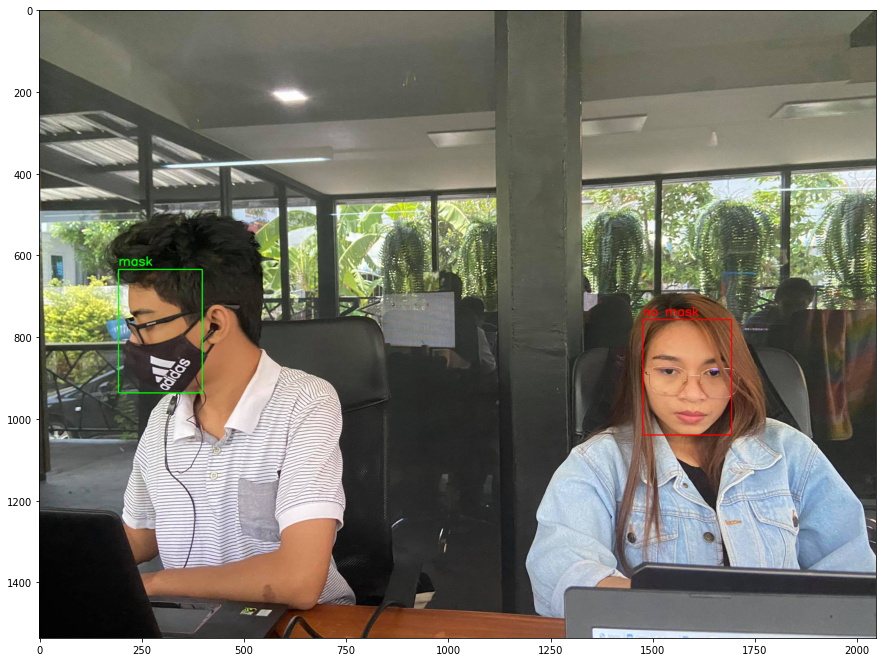

In [53]:
plt.imshow(vis_image)